## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 68, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(68, 136, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(136, 272, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(272, 544, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(544, 1088, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(1088, 2176, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [19]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transformed = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transformed is not None), 'Define a data_transform'

In [20]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='training_frames_keypoints.csv',
                                      root_dir='C:/Users/shanm/Facial-Keypoint-Detection/data/training/',
                                             transform=data_transformed)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [21]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [28]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='C:/Users/shanm/Facial-Keypoint-Detection/data/test_frames_keypoints.csv',
                                      root_dir='C:/Users/shanm/Facial-Keypoint-Detection/data/test/',
                                             transform=data_transformed)
print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = test_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())



Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [29]:
# load test data in batches
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [30]:
# test the model on a batch of test images

if  torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print('Training on GPU ...')
else:
    dtype = torch.FloatTensor
    print('Training on CPU ...')


def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(dtype)

        # forward pass to get net output
        if dtype == torch.cuda.FloatTensor:
            net.cuda()

        output_pts = net(images)

        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

Training on CPU ...


#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [31]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [32]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

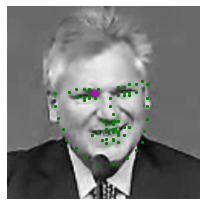

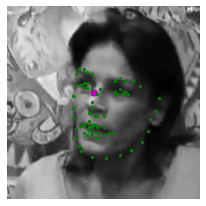

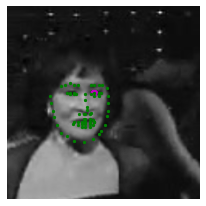

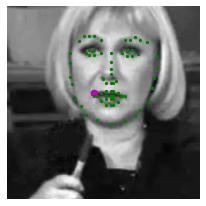

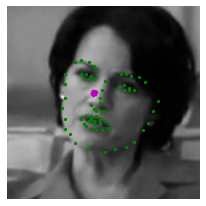

In [33]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
if dtype == torch.cuda.FloatTensor:
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
    gt_pts = gt_pts.cpu()
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

# class torch.nn.MSELoss(size_average=None, reduce=None, reduction='elementwise_mean')
criterion = torch.nn.MSELoss()

# class torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.Adam(net.parameters())

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
# Load checkpoint after running dataset and model arch code
def load_checkpoint(model, filepath):
    checkpoint = torch.load(filepath)
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses_list']
    val_losses = checkpoint['val_losses_list']
    valid_loss_min = checkpoint['valid_loss_min']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, epoch, train_losses, val_losses, valid_loss_min

In [15]:
import time
def train_function(optimizer, model, decay_lr_every=20, starting_epoch=0, n_epochs=100, train_losses=[], 
                   val_losses=[], valid_loss_min=np.Inf):
    
    print_every = 30
    current_epoch = starting_epoch        

    for epoch in range(starting_epoch, n_epochs):

        # monitor training loss
        train_loss = 0.0
        val_loss = 0.0
        steps = 0
        time_sum = 0
        tmp_loss = 0.0
        img_size_sum = 0.0

        model.train() # prep model for training

        for data in train_loader:        

            tic = int(round(time.time() * 1000))  # start timer        
            steps += 1
        
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to CUDA floats for regression loss
            key_pts = key_pts.type(dtype)
            images = images.type(dtype)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass to get outputs
            output_pts = net(images)
            
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()          

            # Give more accurate result where last batch has reduced size
            bch_loss = loss.item()*images.size(0)
            train_loss += bch_loss
            tmp_loss += bch_loss
            img_size_sum += images.size(0)

            toc = int(round(time.time() * 1000))
            batch_training_time_secs = ((toc - tic) / 1000)
            time_sum += batch_training_time_secs

            if steps % print_every == 0:    # print every 'print_every' batches
                    avg_loss = (tmp_loss/img_size_sum)

                    print('Epoch: {}\t Batch: {}\t Avg. Batch Loss: {}\t\t Time (secs): {}'.format(epoch + 1, steps, round(avg_loss,15), round(time_sum, 2)))
                    time_sum = 0
                    tmp_loss = 0.0
                    img_size_sum = 0

        else:
            # else, meaning at end of loop run       
            # Track the loss and accuracy on the validation set to determine the best hyperparameters
            # Turn off gradients for validation, saves memory and computations

            model.eval()

            for data in test_loader:
                
                # get the input images and their corresponding labels
                images = data['image']
                key_pts = data['keypoints']

                # flatten pts
                key_pts = key_pts.view(key_pts.size(0), -1)

                # convert variables to CUDA floats for regression loss
                key_pts = key_pts.type(dtype)
                images = images.type(dtype)

                # forward pass to get outputs
                output_pts = net(images)

                # calculate the loss between predicted and target keypoints
                loss = criterion(output_pts, key_pts)

                val_loss += loss.item()*images.size(0)                


            # calculate average loss over an epoch
            train_loss = train_loss/len(train_loader.dataset)
            val_loss = val_loss/len(test_loader.dataset)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                  "Training Loss: {:.6f}.. ".format(train_loss),
                  "Val. Loss: {:.6f}.. ".format(val_loss), end=' ') # end=' ', next print will be on same line
                
            # Exlude np.Inf from min validation
            if valid_loss_min == np.Inf:
                valid_loss_min = val_loss
                
            # Define checkpoint parameters
            def get_checkpoint():    
                return   {'epoch': epoch,
                          'train_losses_list':train_losses,
                          'val_losses_list':val_losses,
                          'valid_loss_min':valid_loss_min,
                          'state_dict': model.state_dict()}
            
            
            # save model if validation loss has decreased    
            if val_loss <= valid_loss_min:                
                print('Saving val model.')
                valid_loss_min = val_loss
                
                # Save the checkpoint 
                torch.save(get_checkpoint(), 'checkpoint_val.pth')
                
            else:
                # clear buffer
                print("")
                
                                 
            # Always save the latest checkpoint 
            torch.save(get_checkpoint(), 'checkpoint.pth')

In [16]:
# train your network
#n_epochs, start small, and increase when you've decided on your model structure and hyperparams

train_function(optimizer, net, starting_epoch=0, n_epochs=60, train_losses=[], val_losses=[], valid_loss_min=np.Inf)

Epoch: 1	 Batch: 30	 Avg. Batch Loss: 1.378522776067257		 Time (secs): 17.17
Epoch: 1	 Batch: 60	 Avg. Batch Loss: 0.197147882978121		 Time (secs): 16.96
Epoch: 1	 Batch: 90	 Avg. Batch Loss: 0.196180746455987		 Time (secs): 17.04
Epoch: 1/60..  Training Loss: 0.524..  Val. Loss: 0.164..  Saving val model.
Epoch: 2	 Batch: 30	 Avg. Batch Loss: 0.201380605995655		 Time (secs): 17.07
Epoch: 2	 Batch: 60	 Avg. Batch Loss: 0.207234856983026		 Time (secs): 17.08
Epoch: 2	 Batch: 90	 Avg. Batch Loss: 0.174042304605246		 Time (secs): 17.08
Epoch: 2/60..  Training Loss: 0.196..  Val. Loss: 0.180..  
Epoch: 3	 Batch: 30	 Avg. Batch Loss: 0.190762494504452		 Time (secs): 17.09
Epoch: 3	 Batch: 60	 Avg. Batch Loss: 0.199308025836945		 Time (secs): 17.09
Epoch: 3	 Batch: 90	 Avg. Batch Loss: 0.176716617494822		 Time (secs): 17.08
Epoch: 3/60..  Training Loss: 0.189..  Val. Loss: 0.166..  
Epoch: 4	 Batch: 30	 Avg. Batch Loss: 0.184293659031391		 Time (secs): 17.07
Epoch: 4	 Batch: 60	 Avg. Batch L

In [17]:
# Load the Model with the chosen metric
net, epoch, train_losses, val_losses, valid_loss_min = load_checkpoint(net, 'checkpoint.pth')

In [ ]:
train_function(optimizer, model=net, starting_epoch=epoch+1, n_epochs=100, train_losses=train_losses, 
               val_losses=val_losses, valid_loss_min=valid_loss_min)

Epoch: 61	 Batch: 30	 Avg. Batch Loss: 0.020574753110607		 Time (secs): 16.92
Epoch: 61	 Batch: 60	 Avg. Batch Loss: 0.022542283715059		 Time (secs): 16.87
Epoch: 61	 Batch: 90	 Avg. Batch Loss: 0.025883405500402		 Time (secs): 16.92
Epoch: 61/100..  Training Loss: 0.024..  Val. Loss: 0.020..  
Epoch: 62	 Batch: 30	 Avg. Batch Loss: 0.027166686734806		 Time (secs): 16.96
Epoch: 62	 Batch: 60	 Avg. Batch Loss: 0.023438046872616		 Time (secs): 16.97
Epoch: 62	 Batch: 90	 Avg. Batch Loss: 0.028218764252961		 Time (secs): 16.98
Epoch: 62/100..  Training Loss: 0.025..  Val. Loss: 0.020..  
Epoch: 63	 Batch: 30	 Avg. Batch Loss: 0.028654783250143		 Time (secs): 17.02
Epoch: 63	 Batch: 60	 Avg. Batch Loss: 0.016617738269269		 Time (secs): 17.01
Epoch: 63	 Batch: 90	 Avg. Batch Loss: 0.016522493368636		 Time (secs): 17.01
Epoch: 63/100..  Training Loss: 0.021..  Val. Loss: 0.021..  
Epoch: 64	 Batch: 30	 Avg. Batch Loss: 0.027317168160031		 Time (secs): 17.03
Epoch: 64	 Batch: 60	 Avg. Batch L

In [19]:
# Load the Model with the chosen metric
net, epoch, train_losses, val_losses, valid_loss_min = load_checkpoint(net, 'checkpoint.pth')

In [20]:
train_function(optimizer, model=net, starting_epoch=epoch, n_epochs=100, train_losses=train_losses, 
               val_losses=val_losses, valid_loss_min=valid_loss_min)

Epoch: 100	 Batch: 30	 Avg. Batch Loss: 0.015405927101771		 Time (secs): 16.86
Epoch: 100	 Batch: 60	 Avg. Batch Loss: 0.013375641653935		 Time (secs): 16.81
Epoch: 100	 Batch: 90	 Avg. Batch Loss: 0.014455843654772		 Time (secs): 16.9
Epoch: 100/100..  Training Loss: 0.014..  Val. Loss: 0.011..  


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


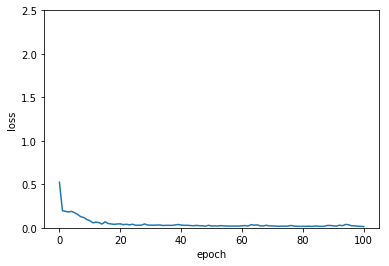

In [22]:
# visualize the loss as the network trained
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

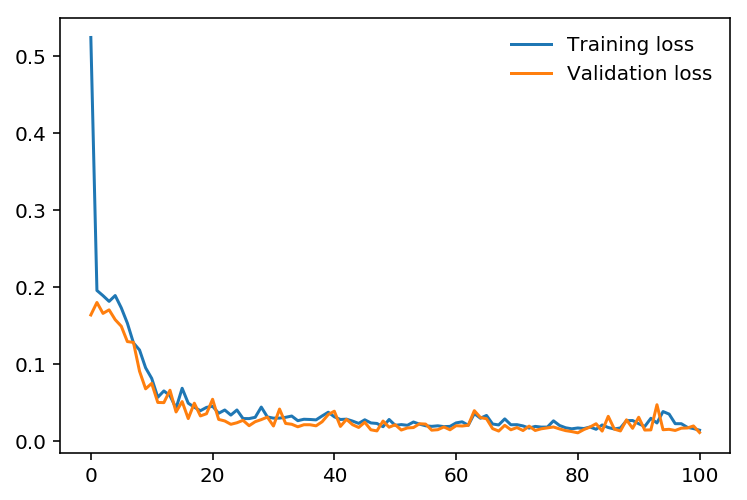

In [25]:
# visualize the train and val loss as the network trained
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

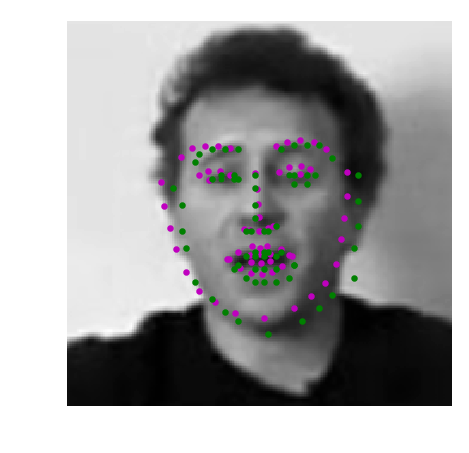

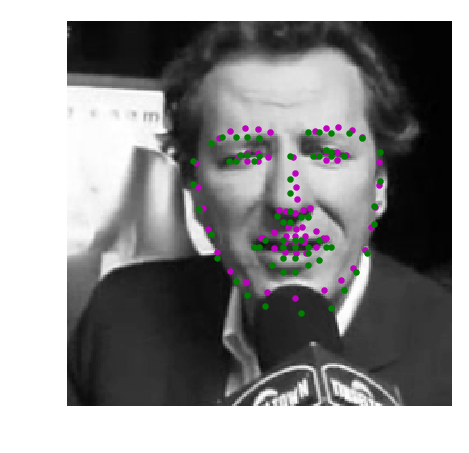

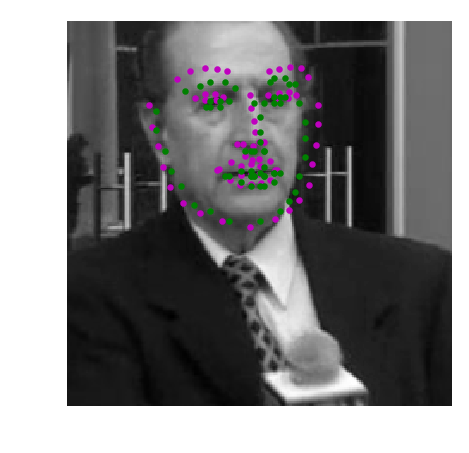

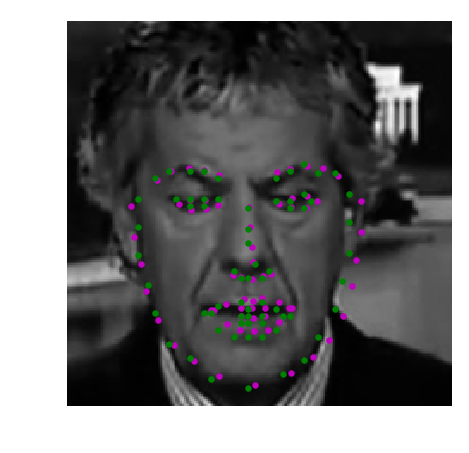

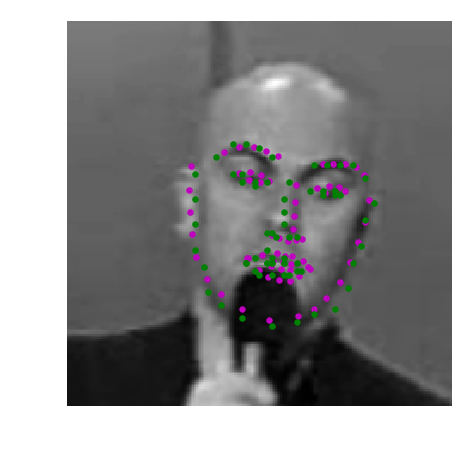

In [26]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
if dtype == torch.cuda.FloatTensor:
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
    gt_pts = gt_pts.cpu()
visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [27]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_drop.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: The optimization function used in the project is the PyTorch implementation of the Adam optimization algorithm, while the loss function is the mean squared error function. The Adam algorithm was chosen because it has been shown to speed up convergence by using momentum to avoid local optima, thereby reducing the number of epochs required. Similarly, the mean square error loss function was chosen because the problem of keypoint detection is a regression problem and is suitably described with the mean square error loss.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: The initial network architecture was a 5 layer LeNet style convolutional neural network (CNN) with filter size of 5, with 68 initial filters, stride of one, with 3 dense layers, but without dropout. The first two dense layers had 9792 neurons each, while the output layer had 136 neurons. The initial network was modified and trained on three epochs, and the effect of the modification was observed on the train set. Some of the modifications made were: reducing the filter size from 5 to 3, introducing dropout layer after the first dense layer, gradually reducing the learning rate, using the activation function on the last dense layer, and increasing the number of dense layers. However, the change with the most significant impact was to increase the number of CNN layers from 5 to 6. In the final model, the number of neurons in each of the first and second dense layers was reduced to 1000. With respect to overfitting, the dropout layer was kept to reduce overfiting. Using dropout made the training error to reduce earlier during training, and the loss per iteration curve smoother. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: The number of epochs was decided by observing the plot of the loss with iterations, the model seemed fully converged, by having a stable value, after about 40 epochs. The batch size was determined by the memory size of the K80 GPU and model complexity, up to 60 images per iteration fit into its memory, while a batch size of 64 caused memory overflow.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [21]:
# instantiate your Net
net = Net()
model_dir = 'saved_models/'
model_name = 'keypoints_model_drop.pt'

# load the net parameters by name
# uncomment and write the name of a saved model
net.load_state_dict(torch.load(model_dir+model_name))

(68, 1, 3, 3)
[[ 0.27265385 -0.24785191 -0.10709018]
 [ 0.13159516  0.18308328 -0.22936387]
 [ 0.14635712  0.29979619  0.136228  ]]
(3, 3)


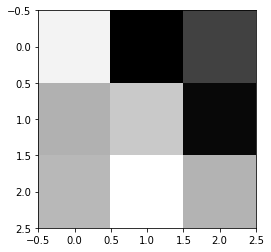

In [22]:
%matplotlib inline
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data
weights1 = weights1.cpu()
w = weights1.numpy()

print(w.shape)

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

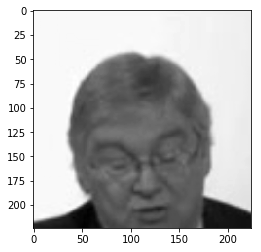

In [23]:
import cv2
##TODO: load in and display any image from the transformed test dataset

# un-transform the image data
image = test_images[i].data   # get the image from it's wrapper
image = image.cpu()
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
image = np.squeeze(image)

# plot image
plt.imshow(image, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)
# 2nd arg, ddepth – desired depth of the destination image; if it is negative, it will be the same as src.depth();
filtered_image = cv2.filter2D(image, -1, w[filter_index][0])


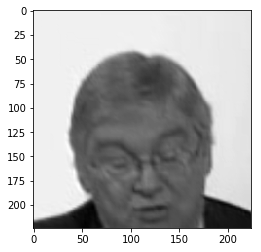

In [24]:
plt.imshow(filtered_image, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The filter above increases average pixel intensity.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!